# LSTM Model Training for Stock Prediction

This notebook trains LSTM models for predicting stock price movements for:
- 20 different stocks
- 3 prediction periods (day, week, month)

The trained models will be saved to `../model/lstm/period/lstm_stock_period.h5`

## 1. Import Libraries and Setup

### 1.1. Importing Libraries and Initial Configuration

This cell handles the initial setup for the notebook. It performs the following actions:
- **Imports necessary libraries:** 
  - `pandas` for data manipulation and analysis.
  - `numpy` for numerical operations.
  - `os` for interacting with the operating system (e.g., creating directories).
  - `matplotlib.pyplot` for plotting graphs.
  - `sklearn.preprocessing.MinMaxScaler` for feature scaling (though not used directly in this cell, it's a common preprocessing step, its absence in direct use here implies data is pre-scaled or scaling is handled elsewhere).
  - `sklearn.model_selection.train_test_split` for splitting data into training, validation, and test sets.
  - `tensorflow.keras` components (`Sequential`, `LSTM`, `Dense`, `Dropout`, `EarlyStopping`, `ModelCheckpoint`, `Adam`) for building and training the LSTM neural network.
- **Suppresses warnings:** `warnings.filterwarnings('ignore')` is used to prevent display of warning messages, which can be helpful for cleaner output during development and execution.
- **Sets random seeds:** `np.random.seed(42)`, `random.seed(42)`, and `tf.random.set_seed(42)` are set to ensure reproducibility of results. By fixing the seed, the random processes involved in model training (like weight initialization and data shuffling if any) will produce the same outcome each time the code is run.
- **Defines the list of stocks:** A list named `stocks` contains the ticker symbols of 20 companies for which models will be trained.
- **Defines prediction periods:** A list named `periods` specifies the timeframes for prediction ('day', 'week', 'month').
- **Creates output directories:** It iterates through the defined `periods` and creates directories (`../model/lstm/{period}`) to store the trained LSTM models for each period. `exist_ok=True` ensures that the script doesn't raise an error if the directories already exist.

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
import random
import tensorflow as tf
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

# Define the list of stocks to process
stocks = [
    'AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA', 'META', 'NVDA', 'SPY', 'V', 'DIS',
    'NFLX', 'PYPL', 'BABA', 'IBM', 'AMD', 'BA', 'INTC', 'T', 'GS', 'NKE'
]

# Define periods
periods = ['day', 'week', 'month']

# Create output directories
for period in periods:
    os.makedirs(f'../model/lstm/{period}', exist_ok=True)
print("Output directories created.")

## 2. Data Loading and Preparation Functions

### 2.1. `load_data` Function

This function is designed to load pre-processed data for a specific stock and prediction period.
- **Parameters:**
  - `stock` (str): The ticker symbol of the stock.
  - `period` (str): The prediction period ('day', 'week', 'month').
- **Functionality:**
  - It constructs the file path for the CSV file, which is expected to be in `../data/lstm/{period}/{stock}_lstm_{period}.csv`.
  - It checks if the file exists using `os.path.exists()`.
  - If the file does not exist, it prints a warning message and returns `None`.
  - If the file exists, it reads the CSV file into a pandas DataFrame using `pd.read_csv()` and returns the DataFrame.
This function centralizes data loading and includes basic error handling for missing files.

In [ ]:
def load_data(stock, period):
    """Load prepared data from CSV"""
    file_path = f'../data/lstm/{period}/{stock}_lstm_{period}.csv'
    
    if not os.path.exists(file_path):
        print(f"Warning: File {file_path} does not exist. Skipping.")
        return None
    
    df = pd.read_csv(file_path)
    return df

### 2.2. `prepare_lstm_data` Function

This function prepares the input DataFrame for LSTM model training by transforming it into sequences and splitting it into training, validation, and test sets.
- **Parameters:**
  - `df` (pd.DataFrame): The input DataFrame containing features and the target variable.
  - `target_col` (str): The name of the column to be used as the target variable.
  - `time_steps` (int, default=10): The number of past time steps to use for creating sequences. Each sequence will have `time_steps` feature sets to predict the target at the next step.
  - `test_size` (float, default=0.2): The proportion of the dataset to allocate to the test set.
  - `validation_size` (float, default=0.2): The proportion of the *remaining* data (after test split) to allocate to the validation set. Note: The actual validation split size is adjusted relative to the size of the data *after* the initial test split.
- **Functionality:**
  1. **Date Handling:** If a 'date' column exists, it converts it to datetime objects, sorts the DataFrame by date, and then drops the 'date' column as it's typically not used as a direct feature in LSTMs after ensuring chronological order.
  2. **Feature and Target Separation:** It separates the target variable (`y`) from the features (`X`).
  3. **Sequence Creation:** It iterates through the data to create sequences. For each position `i`, it takes `X[i:i + time_steps]` as the input sequence and `y[i + time_steps]` as the corresponding target. This creates overlapping sequences suitable for LSTM input.
  4. **Data Splitting:**
     - The sequenced data (`X_seq`, `y_seq`) is first split into a temporary training set (`X_train_temp`, `y_train_temp`) and a test set (`X_test`, `y_test`) using `train_test_split`. `shuffle=False` is crucial here to maintain the chronological order of time-series data, ensuring that the model is tested on future data relative to its training and validation data.
     - The temporary training set is then further split into the final training set (`X_train`, `y_train`) and a validation set (`X_val`, `y_val`), again with `shuffle=False`. The `validation_size` is adjusted (`val_size_adjusted`) to reflect the proportion of the original temporary training set.
  5. **Return Values:** The function returns the split datasets: `X_train`, `X_val`, `X_test`, `y_train`, `y_val`, `y_test`.

In [ ]:
def prepare_lstm_data(df, target_col, time_steps=10, test_size=0.2, validation_size=0.2):
    """Prepare data for LSTM model training with sequences"""
    # Convert date column to datetime and sort
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.sort_values('date', inplace=True)
        df = df.drop(columns=['date'])  # Remove date after sorting
    
    # Extract features and target
    y = df[target_col].values
    X = df.drop(columns=[target_col]).values
    
    # Create sequences for LSTM
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i + time_steps])
        y_seq.append(y[i + time_steps])
    
    X_seq = np.array(X_seq)
    y_seq = np.array(y_seq)
    
    # Split into training and temporary test sets
    X_train_temp, X_test, y_train_temp, y_test = train_test_split(
        X_seq, y_seq, test_size=test_size, shuffle=False
    )
    
    # Split training set into actual training and validation sets
    val_size_adjusted = validation_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_temp, y_train_temp, test_size=val_size_adjusted, shuffle=False
    )
    
    return X_train, X_val, X_test, y_train, y_val, y_test

## 3. Model Building Function

### 3.1. `build_lstm_model` Function

This function defines and compiles the LSTM neural network architecture for binary classification (predicting stock price movement direction).
- **Parameters:**
  - `input_shape` (tuple): The shape of the input data, typically `(time_steps, num_features)`.
  - `lstm_units` (int, default=64): The number of units in the first LSTM layer.
The second LSTM layer will have `lstm_units // 2` units.
  - `dropout_rate` (float, default=0.2): The dropout rate to apply after each LSTM layer to prevent overfitting.
  - `learning_rate` (float, default=0.001): The learning rate for the Adam optimizer.
- **Functionality:**
  1. **Model Architecture (Sequential API):**
     - An `LSTM` layer with `lstm_units` and `return_sequences=True`. `return_sequences=True` is used because it's followed by another LSTM layer, so it needs to output the full sequence.
     - A `Dropout` layer with the specified `dropout_rate`.
     - A second `LSTM` layer with `lstm_units // 2` units. `return_sequences=False` (default) here as it's followed by Dense layers, so only the output of the last time step is needed.
     - A `Dropout` layer with the specified `dropout_rate`.
     - A `Dense` layer with 32 units and 'relu' activation function, acting as a hidden layer for further feature extraction.
     - An output `Dense` layer with 1 unit and 'sigmoid' activation function. This is suitable for binary classification, producing a probability score between 0 and 1.
  2. **Optimizer:**
     - The `Adam` optimizer is used with the specified `learning_rate`.
  3. **Model Compilation:**
     - The model is compiled with:
       - `optimizer`: The configured Adam optimizer.
       - `loss`: 'binary_crossentropy', which is appropriate for binary classification tasks where the output is a probability.
       - `metrics`: ['accuracy'] to monitor the classification accuracy during training and evaluation.
  4. **Return Value:** The function returns the compiled Keras `Sequential` model.

In [ ]:
def build_lstm_model(input_shape, lstm_units=64, dropout_rate=0.2, learning_rate=0.001):
    """Build LSTM model for binary classification"""
    model = Sequential([
        LSTM(lstm_units, return_sequences=True, input_shape=input_shape),
        Dropout(dropout_rate),
        LSTM(lstm_units // 2),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

## 4. Quick Parameter Selection Function

### 4.1. `select_parameters` Function

This function implements a simple grid search to find a potentially good set of hyperparameters for the LSTM model. It's a 'quick' selection because it trains models for only a few epochs for each parameter combination.
- **Parameters:**
  - `X_train`, `y_train`: Training data and labels.
  - `X_val`, `y_val`: Validation data and labels.
  - `verbose` (int, default=0): Verbosity mode for model training. If > 0, it prints progress for each parameter combination.
- **Functionality:**
  1. **Parameter Grid Definition:** It defines a small grid of hyperparameters to test:
     - `lstm_units_options`: [32, 64]
     - `dropout_options`: [0.2, 0.3]
     - `learning_rate_options`: [0.001, 0.0005]
  2. **Iterative Search:** It iterates through all possible combinations of these hyperparameters.
     - For each combination, it builds an LSTM model using `build_lstm_model`.
     - It trains the model for a small number of epochs (5 epochs, batch size 32) using the training data and evaluates it on the validation data.
     - The validation accuracy from the last epoch is recorded.
  3. **Best Parameter Tracking:** It keeps track of the parameter combination that yields the highest validation accuracy.
  4. **Output:** It prints the best parameters found and the corresponding best validation accuracy.
  5. **Return Value:** The function returns a dictionary `best_params` containing the 'lstm_units', 'dropout_rate', and 'learning_rate' that achieved the highest validation accuracy during this quick search.

**Note:** This is a simplified hyperparameter tuning approach. More rigorous methods like K-Fold Cross-Validation or more sophisticated search algorithms (e.g., Bayesian Optimization, Random Search over a larger space) could yield better results but are more computationally expensive.

In [ ]:
def select_parameters(X_train, X_val, y_train, y_val, verbose=0):
    """Simple parameter selection for LSTM model"""
    # Define parameter options to try
    lstm_units_options = [32, 64]
    dropout_options = [0.2, 0.3]
    learning_rate_options = [0.001, 0.0005]
    
    best_accuracy = 0
    best_params = {}
    
    # Simple grid search
    for lstm_units in lstm_units_options:
        for dropout_rate in dropout_options:
            for learning_rate in learning_rate_options:
                # Build model with current parameters
                model = build_lstm_model(
                    input_shape=(X_train.shape[1], X_train.shape[2]),
                    lstm_units=lstm_units,
                    dropout_rate=dropout_rate,
                    learning_rate=learning_rate
                )
                
                # Train for a few epochs to get a quick estimate
                history = model.fit(
                    X_train, y_train,
                    epochs=5,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=verbose
                )
                
                # Get validation accuracy
                val_accuracy = history.history['val_accuracy'][-1]
                
                # Print current parameters and accuracy
                if verbose > 0:
                    print(f"LSTM units: {lstm_units}, Dropout: {dropout_rate}, LR: {learning_rate}, Val Acc: {val_accuracy:.4f}")
                
                # Update best parameters if current is better
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {
                        'lstm_units': lstm_units,
                        'dropout_rate': dropout_rate,
                        'learning_rate': learning_rate
                    }
    
    print(f"Best parameters: {best_params}, Best validation accuracy: {best_accuracy:.4f}")
    return best_params

## 5. Model Training Function

### 5.1. `train_lstm_model` Function

This function trains the LSTM model using the provided training and validation data, and a given set of hyperparameters.
- **Parameters:**
  - `X_train`, `y_train`: Training data and labels.
  - `X_val`, `y_val`: Validation data and labels.
  - `params` (dict): A dictionary containing the hyperparameters for the model, specifically 'lstm_units', 'dropout_rate', and 'learning_rate'. This typically comes from the `select_parameters` function or can be manually defined.
  - `epochs` (int, default=50): The maximum number of epochs to train the model.
  - `batch_size` (int, default=32): The number of samples per gradient update.
- **Functionality:**
  1. **Model Building:** It first builds an LSTM model using the `build_lstm_model` function with the hyperparameters passed in the `params` dictionary and the input shape derived from `X_train`.
  2. **Callbacks Setup:**
     - `EarlyStopping`: This callback is configured to monitor the validation loss (`val_loss`). Training will stop if the validation loss does not improve for a specified number of epochs (`patience=10`). `restore_best_weights=True` ensures that the model weights are reset to those from the epoch with the best validation loss at the end of training.
  3. **Model Training:**
     - The model's `fit` method is called with the training data (`X_train`, `y_train`), number of epochs, batch size, and validation data (`X_val`, `y_val`).
     - The `early_stopping` callback is passed to the `callbacks` list.
     - `verbose=1` means that training progress (loss and metrics for each epoch) will be printed.
  4. **Return Values:** The function returns the trained Keras `model` and the `history` object. The history object contains a record of training loss values and metrics values at successive epochs, as well as validation loss values and validation metrics values.

In [ ]:
def train_lstm_model(X_train, X_val, y_train, y_val, params, epochs=50, batch_size=32):
    """Train LSTM model with early stopping"""
    # Build model with selected parameters
    model = build_lstm_model(
        input_shape=(X_train.shape[1], X_train.shape[2]),
        lstm_units=params['lstm_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate']
    )
    
    # Set up callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping],
        verbose=1
    )
    
    return model, history

## 6. Evaluate and Plot Results

### 6.1. `evaluate_lstm_model` Function

This function evaluates the performance of a trained LSTM model on the test set and visualizes the training history and classification results.
- **Parameters:**
  - `model` (tf.keras.Model): The trained LSTM model.
  - `X_test`, `y_test`: Test data and true labels.
  - `history` (tf.keras.callbacks.History): The history object returned by the `model.fit()` method, containing training/validation loss and accuracy.
  - `stock` (str): The ticker symbol of the stock (for labeling plots).
  - `period` (str): The prediction period (for labeling plots).
- **Functionality:**
  1. **Test Set Evaluation:**
     - It evaluates the model on the `X_test` and `y_test` using `model.evaluate()`, obtaining the test loss and test accuracy. The test accuracy is printed.
  2. **Plotting Training History:**
     - It creates a figure with two subplots:
       - **Accuracy Plot:** Plots the training accuracy (`history.history['accuracy']`) and validation accuracy (`history.history['val_accuracy']`) over epochs.
       - **Loss Plot:** Plots the training loss (`history.history['loss']`) and validation loss (`history.history['val_loss']`) over epochs.
     - Both plots are titled and labeled appropriately.
  3. **Generating Predictions:**
     - It generates probability predictions for the test set using `model.predict(X_test)`.
     - These probabilities are converted to binary predictions (0 or 1) by thresholding at 0.5.
  4. **Classification Report:**
     - It imports `confusion_matrix` and `classification_report` from `sklearn.metrics`.
     - It prints the classification report, which includes precision, recall, F1-score, and support for each class (0: Down, 1: Up).
  5. **Plotting Confusion Matrix:**
     - It calculates the confusion matrix using `confusion_matrix(y_test, y_pred)`.
     - It visualizes the confusion matrix as an image plot (`plt.imshow`) with color-coded cells and numerical annotations for true negatives, false positives, false negatives, and true positives.
  6. **Display Plots:** All generated plots are displayed using `plt.show()`.
- **Return Value:** The function returns the `test_accuracy`.

In [76]:
def evaluate_lstm_model(model, X_test, y_test, history, stock, period):
    """Evaluate LSTM model and plot results"""
    # Evaluate on test set
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    print(f"Test accuracy: {test_accuracy:.4f}")
    
    # Plot training history
    plt.figure(figsize=(12, 5))
    
    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title(f'{stock} {period} - Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='lower right')
    
    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title(f'{stock} {period} - Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    
    plt.tight_layout()
    plt.show()
    
    # Generate predictions for test set
    y_pred_prob = model.predict(X_test, verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate confusion matrix
    from sklearn.metrics import confusion_matrix, classification_report
    cm = confusion_matrix(y_test, y_pred)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'{stock} {period} - Confusion Matrix')
    plt.colorbar()
    classes = ['Down', 'Up']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    
    # Add text annotations
    thresh = cm.max() / 2
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    
    return test_accuracy

## 7. Main Processing Function for Single Stock

### 7.1. `process_stock_lstm` Function

This function encapsulates the entire workflow for processing a single stock for a specific prediction period. It handles data loading, preparation, optional parameter selection, model training, evaluation, and saving the model.
- **Parameters:**
  - `stock` (str): The ticker symbol of the stock.
  - `period` (str): The prediction period ('day', 'week', 'month').
  - `time_steps` (int, default=10): The number of time steps for LSTM sequences.
  - `param_selection` (bool, default=True): If `True`, performs quick hyperparameter selection using `select_parameters`. Otherwise, uses default parameters.
  - `plot` (bool, default=True): If `True`, calls `evaluate_lstm_model` to plot results. Otherwise, only prints test accuracy.
- **Functionality:**
  1. **Load Data:** Calls `load_data(stock, period)`. If data is not found, it returns `None`.
  2. **Identify Target Column:** Determines the target column name based on the period (e.g., `Target_Next_Day`). If the target column is not in the DataFrame, it prints an error and returns `None`.
  3. **Prepare Data:** Calls `prepare_lstm_data` to create sequences and split data into train, validation, and test sets.
  4. **Parameter Selection (Optional):**
     - If `param_selection` is `True`, calls `select_parameters` to find the best hyperparameters.
     - Otherwise, it uses a predefined set of default parameters: `lstm_units=64`, `dropout_rate=0.2`, `learning_rate=0.001`.
  5. **Train Model:** Calls `train_lstm_model` with the prepared data and selected (or default) parameters.
  6. **Evaluate Model:**
     - If `plot` is `True`, calls `evaluate_lstm_model` which prints detailed metrics and plots.
     - Otherwise, it evaluates the model on the test set and prints only the test accuracy.
  7. **Save Model:** Saves the trained model to a .h5 file in the path `../model/lstm/{period}/lstm_{stock}_{period}.h5`.
- **Return Value:** Returns the trained Keras `model` object, or `None` if processing failed (e.g., data not found).

In [ ]:
def process_stock_lstm(stock, period, time_steps=10, param_selection=True, plot=True):
    """Process a single stock for a specific prediction period"""
    print(f"\nProcessing {stock} for {period} prediction...")
    
    # Load data
    df = load_data(stock, period)
    if df is None:
        return None
    
    # Get target column name
    target_col = f'Target_Next_{period.capitalize()}'
    if target_col not in df.columns:
        print(f"Error: Target column {target_col} not found in data.")
        return None
    
    # Prepare data
    X_train, X_val, X_test, y_train, y_val, y_test = prepare_lstm_data(
        df, target_col, time_steps=time_steps
    )
    
    print(f"Data shapes: X_train: {X_train.shape}, X_val: {X_val.shape}, X_test: {X_test.shape}")
    
    # Quick parameter selection if enabled
    if param_selection:
        params = select_parameters(X_train, X_val, y_train, y_val)
    else:
        # Default parameters
        params = {
            'lstm_units': 64,
            'dropout_rate': 0.2,
            'learning_rate': 0.001
        }
    
    # Train model
    model, history = train_lstm_model(X_train, X_val, y_train, y_val, params)
    
    # Evaluate model
    if plot:
        test_accuracy = evaluate_lstm_model(model, X_test, y_test, history, stock, period)
    else:
        test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
        print(f"Test accuracy: {test_accuracy:.4f}")
    
    # Save model
    model_path = f'../model/lstm/{period}/lstm_{stock}_{period}.h5'
    model.save(model_path)
    print(f"Model saved to {model_path}")
    
    return model

## 8. Test with Sample Stock

### 8.1. Single Stock Processing Example

This cell demonstrates how to use the `process_stock_lstm` function for a single stock and period. 
- It sets `sample_stock` to 'AAPL' and `sample_period` to 'day'.
- It then calls `process_stock_lstm` with these values, using `time_steps=10`.
- `param_selection=True` enables the quick hyperparameter search for this sample run.
- `plot=True` ensures that evaluation metrics and plots are displayed for this specific stock and period.

This serves as a test case to verify that the entire pipeline (data loading, preparation, parameter selection, training, evaluation, and model saving) works correctly for one instance before potentially running it for all stocks and periods.


Processing AAPL for day prediction...
Data shapes: X_train: (2181, 10, 22), X_val: (727, 10, 22), X_test: (727, 10, 22)
Best parameters: {'lstm_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001}, Best validation accuracy: 0.6534
Epoch 1/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.5576 - loss: 0.6814 - val_accuracy: 0.5970 - val_loss: 0.6681
Epoch 2/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.6209 - loss: 0.6601 - val_accuracy: 0.6259 - val_loss: 0.6555
Epoch 3/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.6608 - loss: 0.6365 - val_accuracy: 0.6396 - val_loss: 0.6454
Epoch 4/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.6670 - loss: 0.6227 - val_accuracy: 0.6451 - val_loss: 0.6372
Epoch 5/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6698 - loss: 0.6151 - val_accuracy: 0.6410 - val_loss: 0.6335
Epoch 6/50
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6768 - loss: 0.6055 - val_accuracy: 0.6506 - val_loss: 0.6312
Ep

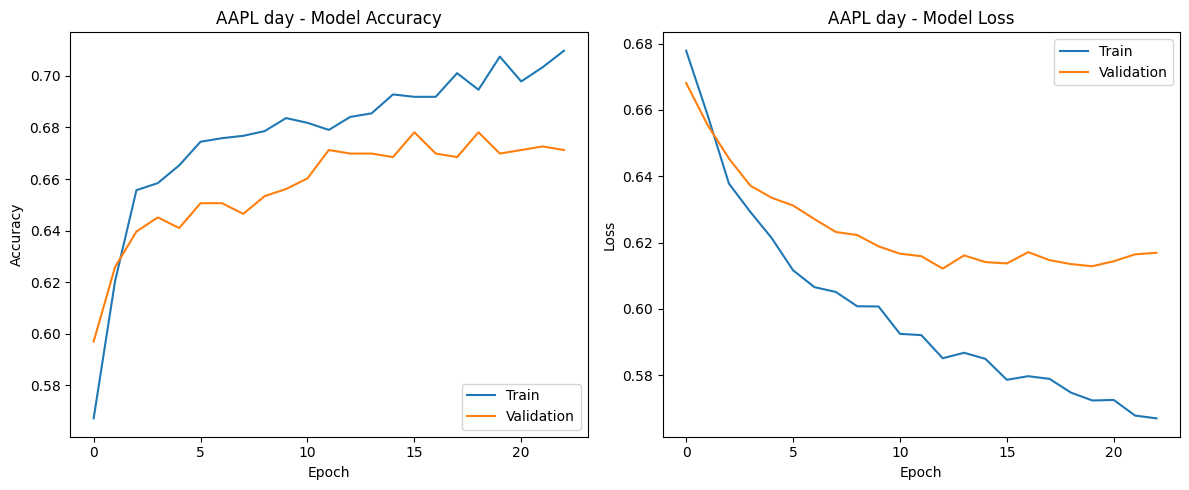


Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.62      0.66       336
           1       0.70      0.77      0.74       391

    accuracy                           0.70       727
   macro avg       0.70      0.70      0.70       727
weighted avg       0.70      0.70      0.70       727



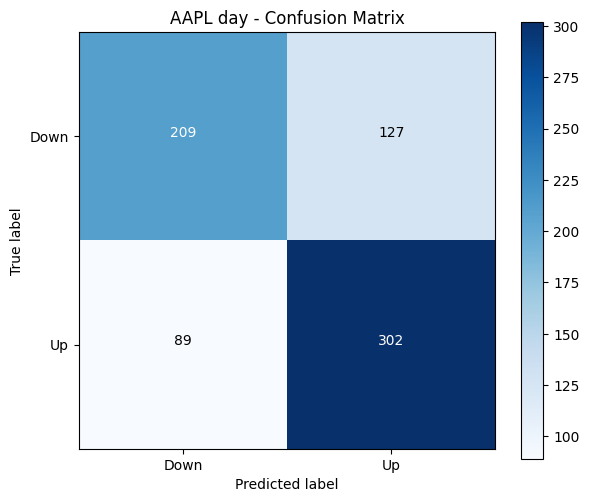

Model saved to ../model/lstm/day/lstm_AAPL_day.h5


In [77]:
# Test with a sample stock
sample_stock = 'AAPL'
sample_period = 'day'

test_model = process_stock_lstm(sample_stock, sample_period, time_steps=10, param_selection=True, plot=True)

## 9. Process All Stocks

### 9.1. `process_all_stocks` Function

This function orchestrates the training of LSTM models for all stocks listed in the `stocks` global variable and for all periods specified in the `periods` global variable.
- **Parameters:**
  - `time_steps` (int, default=10): The number of time steps for LSTM sequences, passed to `process_stock_lstm`.
  - `param_selection` (bool, default=False): Whether to perform hyperparameter selection for each model. For full runs, this is often set to `False` to save time, relying on default or pre-determined good parameters.
  - `plot` (bool, default=False): Whether to generate and display plots for each model during processing. Typically set to `False` for bulk processing to avoid excessive output.
- **Functionality:**
  1. **Initialization:** Initializes an empty dictionary `results` to store the outcome (Success/Failed) of processing for each stock-period combination.
  2. **Iterative Processing:**
     - It iterates through each `stock` in the `stocks` list.
     - For each stock, it iterates through each `period` in the `periods` list.
     - It prints a separator and a message indicating which stock and period are currently being processed.
     - It calls `process_stock_lstm` with the current stock, period, and the provided `time_steps`, `param_selection`, and `plot` arguments.
     - Based on whether `process_stock_lstm` returns a model object (success) or `None` (failure), it records 'Success' or 'Failed' in the `results` dictionary.
  3. **Summary Display:** After processing all combinations, it prints a summary of the results, listing each stock and the status ('Success', 'Failed', or 'Not processed') for each period.
- **Return Value:** Returns the `results` dictionary containing the processing summary.

In [ ]:
def process_all_stocks(time_steps=10, param_selection=False, plot=False):
    """Process all stocks and periods"""
    results = {}
    
    # Process each stock
    for stock in stocks:
        results[stock] = {}
        
        # Process each period
        for period in periods:
            print(f"\n{'='*50}")
            print(f"Training {stock} {period} model")
            print(f"{'='*50}")
            
            # Process the current stock-period combination
            model = process_stock_lstm(
                stock=stock,
                period=period,
                time_steps=time_steps,
                param_selection=param_selection,
                plot=plot
            )
            
            if model is not None:
                results[stock][period] = 'Success'
            else:
                results[stock][period] = 'Failed'
    
    # Display summary
    print("\nProcessing Summary:")
    for stock in stocks:
        print(f"\n{stock}:")
        for period in periods:
            status = results.get(stock, {}).get(period, 'Not processed')
            print(f"  {period}: {status}")
    
    return results

## 10. Run Full Processing

### 10.1. Executing the Full Model Training Pipeline

This cell controls the execution of the `process_all_stocks` function, which trains models for all defined stocks and periods.
- **`process_all` Flag:** A boolean variable `process_all` is used as a switch. 
  - If `process_all` is set to `True`, the `process_all_stocks` function is called.
    - `time_steps=10`: Specifies the LSTM sequence length.
    - `param_selection=False`: Disables hyperparameter search for each model during the bulk run to save computation time. It's assumed that either default parameters are sufficient or optimal parameters have been determined separately.
    - `plot=False`: Disables plotting for each individual model training to keep the output clean and speed up the process.
  - If `process_all` is set to `False`, a message is printed indicating that full processing is disabled, and the user is instructed to set the flag to `True` to run it.

This allows for easily toggling the full training pipeline on or off, which is useful for development and testing versus full-scale model generation.

In [ ]:
# Set to True when ready to process all stocks
process_all = True

if process_all:
    # Process all stocks
    # Set param_selection=False to use default parameters for all models
    # Set plot=False to disable plotting for each model
    processing_results = process_all_stocks(time_steps=10, param_selection=False, plot=False)
else:
    print("Full processing is disabled. Set 'process_all = True' to train all models.")

## 11. Verify Saved Models

### 11.1. `verify_saved_models` Function

This function checks the file system to verify that all expected LSTM model files (one for each stock and period combination) have been saved correctly after the training process.
- **Functionality:**
  1. **Initialization:**
     - Calculates `expected_count`: the total number of models that should have been saved (number of stocks * number of periods).
     - Initializes `found_count` to 0.
     - Initializes an empty list `missing_models` to store the names of models that are not found.
  2. **Verification Loop:**
     - It iterates through each `period` in the global `periods` list.
     - For each period, it iterates through each `stock` in the global `stocks` list.
     - It constructs the expected `model_path` for the current stock and period.
     - It uses `os.path.exists(model_path)` to check if the model file exists at that path.
     - If the file exists, `found_count` is incremented.
     - If the file does not exist, the identifier `f"{stock}_{period}"` is added to the `missing_models` list.
  3. **Reporting Results:**
     - Prints the total number of models found versus the expected count.
     - If there are any missing models:
       - Prints the count of missing models.
       - Lists up to the first 10 missing model identifiers. If more than 10 are missing, it indicates how many more are not listed.
     - If all models are found, it prints a success message.

This function provides a convenient way to audit the output of the model training pipeline.

In [ ]:
def verify_saved_models():
    """Verify that all expected models have been saved"""
    print("Verifying saved models...")
    
    expected_count = len(stocks) * len(periods)
    found_count = 0
    missing_models = []
    
    for period in periods:
        for stock in stocks:
            model_path = f'../model/lstm/{period}/lstm_{stock}_{period}.h5'
            if os.path.exists(model_path):
                found_count += 1
            else:
                missing_models.append(f"{stock}_{period}")
    
    print(f"Found {found_count} out of {expected_count} expected models.")
    
    if missing_models:
        print(f"Missing {len(missing_models)} models:")
        for model in missing_models[:10]:  # Show first 10 if many are missing
            print(f"  - {model}")
        if len(missing_models) > 10:
            print(f"  ...and {len(missing_models) - 10} more")
    else:
        print("All expected models have been saved successfully!")

### 11.2. Conditional Execution of Model Verification

This cell calls the `verify_saved_models()` function. 
- It is conditioned on the `process_all` flag. This means the verification step will only run if the full processing pipeline (controlled by `process_all` in Cell 10.1) was intended to be executed.
- This ensures that model verification is performed after the main training loop has completed (or was supposed to complete), providing a check on the generated artifacts.

In [78]:
# Run this after processing all stocks to verify models were saved
if process_all:
    verify_saved_models()

Verifying saved models...
Found 60 out of 60 expected models.
All expected models have been saved successfully!


## 12. Model Benchmarking

This section performs benchmarking on a subset of the trained models. It loads selected models and evaluates them on their respective test sets to gather key performance metrics. The results are then presented in a table and visualized.

In [79]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Select a subset of stocks for benchmarking
benchmark_stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'TSLA'] # 5 stocks for demonstration
time_steps_benchmark = 10 # Should match the time_steps used for training

benchmark_results = []

print(f"Starting benchmarking for {len(benchmark_stocks)} stocks across {len(periods)} periods...")

for period in periods:
    print(f"\n--- Benchmarking for period: {period.upper()} ---")
    for stock in benchmark_stocks:
        print(f"Processing {stock} for {period}...")
        model_path = f'../model/lstm/{period}/lstm_{stock}_{period}.h5'
        
        if not os.path.exists(model_path):
            print(f"Model not found for {stock} - {period}. Skipping.")
            benchmark_results.append({
                'Stock': stock,
                'Period': period,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1-Score': np.nan,
                'AUC': np.nan,
                'Status': 'Model Missing'
            })
            continue
        
        try:
            model = load_model(model_path)
            df = load_data(stock, period)
            
            if df is None:
                print(f"Data not found for {stock} - {period}. Skipping.")
                benchmark_results.append({
                    'Stock': stock,
                    'Period': period,
                    'Accuracy': np.nan,
                    'Precision': np.nan,
                    'Recall': np.nan,
                    'F1-Score': np.nan,
                    'AUC': np.nan,
                    'Status': 'Data Missing'
                })
                continue
            
            target_col = f'Target_Next_{period.capitalize()}'
            if target_col not in df.columns:
                print(f"Target column {target_col} not found for {stock} - {period}. Skipping.")
                benchmark_results.append({
                    'Stock': stock,
                    'Period': period,
                    'Accuracy': np.nan,
                    'Precision': np.nan,
                    'Recall': np.nan,
                    'F1-Score': np.nan,
                    'AUC': np.nan,
                    'Status': 'Target Col Missing'
                })
                continue

            # Re-prepare data to get the exact X_test, y_test split
            # Ensure parameters match those used in training (time_steps, test_size, validation_size)
            _, _, X_test, _, _, y_test = prepare_lstm_data(
                df, target_col, time_steps=time_steps_benchmark, test_size=0.2, validation_size=0.2
            )
            
            if X_test.shape[0] == 0:
                print(f"Test set is empty for {stock} - {period} after preparation. Skipping.")
                benchmark_results.append({
                    'Stock': stock,
                    'Period': period,
                    'Accuracy': np.nan,
                    'Precision': np.nan,
                    'Recall': np.nan,
                    'F1-Score': np.nan,
                    'AUC': np.nan,
                    'Status': 'Empty Test Set'
                })
                continue

            y_pred_prob = model.predict(X_test, verbose=0).flatten()
            y_pred = (y_pred_prob > 0.5).astype(int)
            
            accuracy = accuracy_score(y_test, y_pred)
            precision = precision_score(y_test, y_pred, zero_division=0)
            recall = recall_score(y_test, y_pred, zero_division=0)
            f1 = f1_score(y_test, y_pred, zero_division=0)
            auc = roc_auc_score(y_test, y_pred_prob) if len(np.unique(y_test)) > 1 else np.nan # AUC requires at least two classes in y_true
            
            benchmark_results.append({
                'Stock': stock,
                'Period': period,
                'Accuracy': accuracy,
                'Precision': precision,
                'Recall': recall,
                'F1-Score': f1,
                'AUC': auc,
                'Status': 'Success'
            })
            print(f"Successfully benchmarked {stock} - {period}. F1: {f1:.4f}, AUC: {auc if not np.isnan(auc) else 'N/A':.4f}")
        
        except Exception as e:
            print(f"Error benchmarking {stock} - {period}: {e}")
            benchmark_results.append({
                'Stock': stock,
                'Period': period,
                'Accuracy': np.nan,
                'Precision': np.nan,
                'Recall': np.nan,
                'F1-Score': np.nan,
                'AUC': np.nan,
                'Status': f'Error: {str(e)[:50]}...'
            })

benchmark_df = pd.DataFrame(benchmark_results)
print("\n--- Benchmarking Complete ---")

Starting benchmarking for 5 stocks across 3 periods...

--- Benchmarking for period: DAY ---
Processing AAPL for day...


Successfully benchmarked AAPL - day. F1: 0.7366, AUC: 0.7550
Processing MSFT for day...


Successfully benchmarked MSFT - day. F1: 0.7290, AUC: 0.7132
Processing GOOG for day...


Successfully benchmarked GOOG - day. F1: 0.7171, AUC: 0.7432
Processing AMZN for day...
Successfully benchmarked AMZN - day. F1: 0.6722, AUC: 0.7280
Processing TSLA for day...


Successfully benchmarked TSLA - day. F1: 0.6687, AUC: 0.7438

--- Benchmarking for period: WEEK ---
Processing AAPL for week...


Successfully benchmarked AAPL - week. F1: 0.8676, AUC: 0.9132
Processing MSFT for week...
Successfully benchmarked MSFT - week. F1: 0.8404, AUC: 0.9011
Processing GOOG for week...


Successfully benchmarked GOOG - week. F1: 0.8450, AUC: 0.9083
Processing AMZN for week...


Successfully benchmarked AMZN - week. F1: 0.8465, AUC: 0.9126
Processing TSLA for week...


Successfully benchmarked TSLA - week. F1: 0.8102, AUC: 0.8972

--- Benchmarking for period: MONTH ---
Processing AAPL for month...
Successfully benchmarked AAPL - month. F1: 0.9011, AUC: 0.9501
Processing MSFT for month...


Successfully benchmarked MSFT - month. F1: 0.9025, AUC: 0.9403
Processing GOOG for month...
Successfully benchmarked GOOG - month. F1: 0.9023, AUC: 0.9653
Processing AMZN for month...


Successfully benchmarked AMZN - month. F1: 0.9060, AUC: 0.9466
Processing TSLA for month...


Successfully benchmarked TSLA - month. F1: 0.8464, AUC: 0.9455

--- Benchmarking Complete ---


### 12.1. Benchmarking Results Table

The table below summarizes the performance metrics (Accuracy, Precision, Recall, F1-Score, AUC) for the selected stocks across different prediction periods.

In [80]:
if not benchmark_df.empty:
    display(benchmark_df.style.format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}',
        'AUC': '{:.4f}'
    }).hide_index() if 'Status' not in benchmark_df.columns else benchmark_df.style.format({
        'Accuracy': '{:.4f}',
        'Precision': '{:.4f}',
        'Recall': '{:.4f}',
        'F1-Score': '{:.4f}',
        'AUC': '{:.4f}'
    }))
else:
    print("Benchmarking DataFrame is empty. No results to display.")

,Stock,Period,Accuracy,Precision,Recall,F1-Score,AUC,Status
0,AAPL,day,0.7029,0.7040,0.7724,0.7366,0.7550,Success
1,MSFT,day,0.6451,0.6056,0.9156,0.7290,0.7132,Success
2,GOOG,day,0.6809,0.6774,0.7617,0.7171,0.7432,Success
3,AMZN,day,0.6740,0.6963,0.6497,0.6722,0.7280,Success
4,TSLA,day,0.6842,0.7134,0.6292,0.6687,0.7438,Success
5,AAPL,week,0.8514,0.8741,0.8613,0.8676,0.9132,Success
6,MSFT,week,0.8239,0.8362,0.8446,0.8404,0.9011,Success
7,GOOG,week,0.8349,0.8583,0.8321,0.8450,0.9083,Success
8,AMZN,week,0.8294,0.8261,0.8680,0.8465,0.9126,Success
9,TSLA,week,0.8208,0.8406,0.7820,0.8102,0.8972,Success


### 12.2. Benchmarking Visualizations

The following visualizations provide a comparative view of model performance.

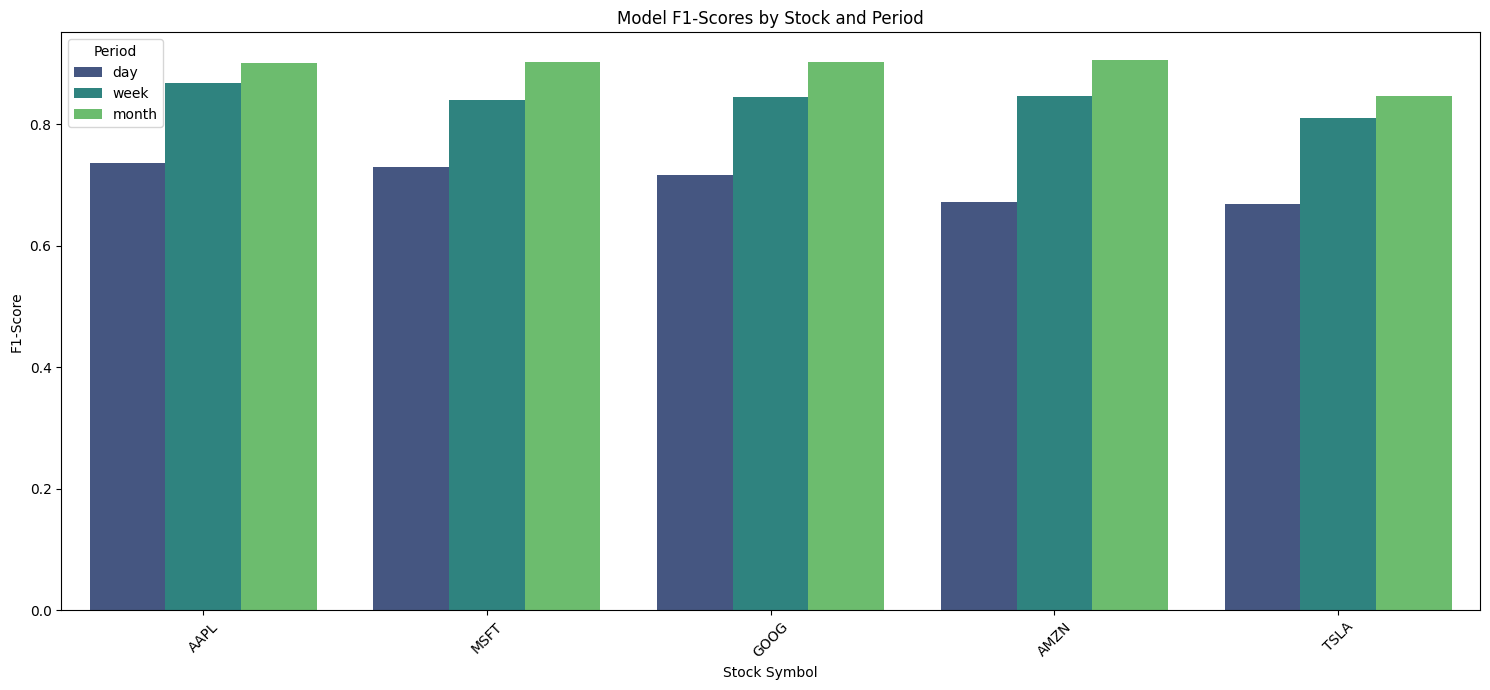

In [81]:
if not benchmark_df.empty and 'F1-Score' in benchmark_df.columns:
    # Filter out rows with NaN F1-scores for plotting
    plot_df_f1 = benchmark_df.dropna(subset=['F1-Score'])
    if not plot_df_f1.empty:
        plt.figure(figsize=(15, 7))
        sns.barplot(data=plot_df_f1, x='Stock', y='F1-Score', hue='Period', palette='viridis')
        plt.title('Model F1-Scores by Stock and Period')
        plt.ylabel('F1-Score')
        plt.xlabel('Stock Symbol')
        plt.xticks(rotation=45)
        plt.legend(title='Period')
        plt.tight_layout()
        plt.show()
    else:
        print("No valid F1-Score data to plot after filtering NaNs.")
else:
    print("Benchmarking DataFrame is empty or F1-Score column missing, skipping F1-Score plot.")

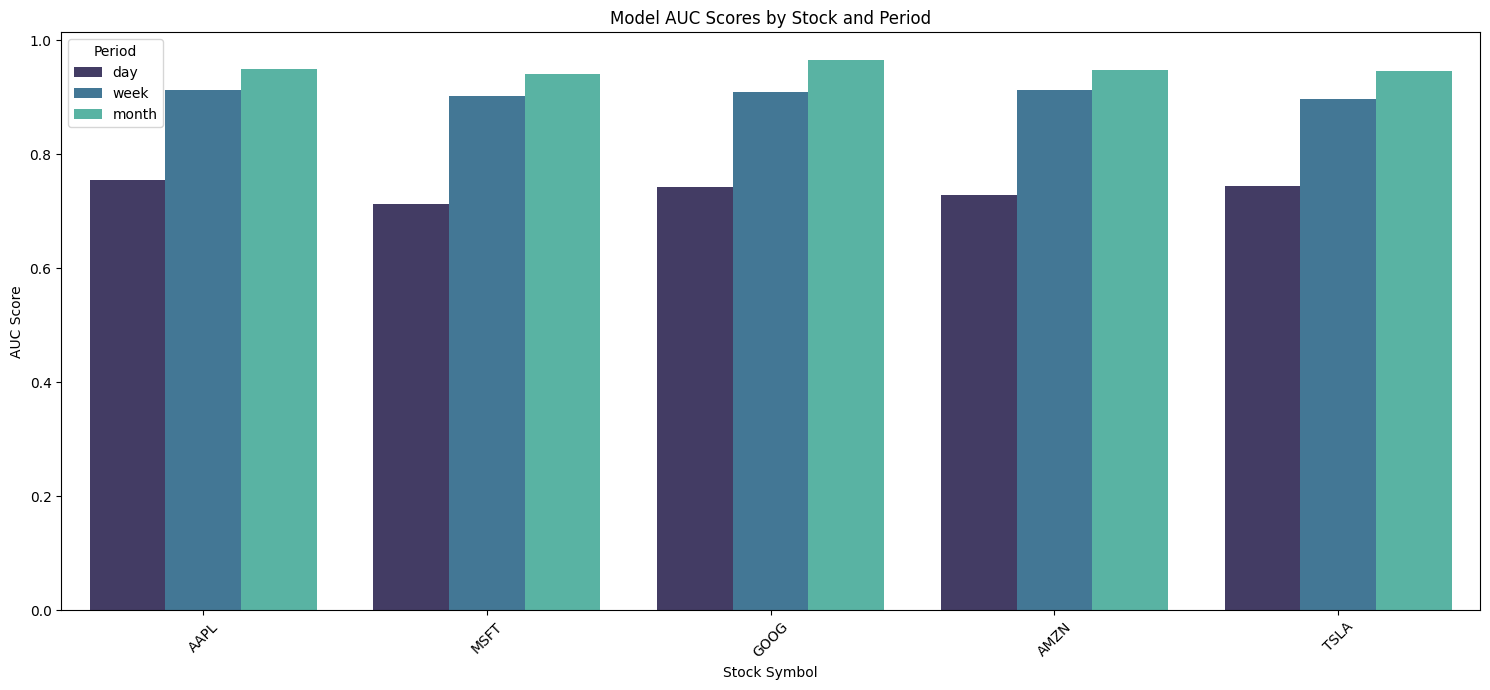

In [82]:
if not benchmark_df.empty and 'AUC' in benchmark_df.columns:
    # Filter out rows with NaN AUC scores for plotting
    plot_df_auc = benchmark_df.dropna(subset=['AUC'])
    if not plot_df_auc.empty:
        plt.figure(figsize=(15, 7))
        sns.barplot(data=plot_df_auc, x='Stock', y='AUC', hue='Period', palette='mako')
        plt.title('Model AUC Scores by Stock and Period')
        plt.ylabel('AUC Score')
        plt.xlabel('Stock Symbol')
        plt.xticks(rotation=45)
        plt.legend(title='Period')
        plt.tight_layout()
        plt.show()
    else:
        print("No valid AUC data to plot after filtering NaNs.")
else:
    print("Benchmarking DataFrame is empty or AUC column missing, skipping AUC plot.")

## 13. Advanced Model Performance Analysis (Utility Function)

The following function, `analyze_model_performance`, is a utility for conducting a more detailed performance analysis of a *single* trained model. It's not directly part of the main training loop but can be used for deeper dives into specific models.

In [83]:
def analyze_model_performance(model, X_test, y_test, stock, period):
    """Generate detailed performance metrics and ROC curve"""
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    import matplotlib.pyplot as plt
    import seaborn as sns # Seaborn was imported but not used here, can be removed if not intended
    
    # Get predictions
    y_pred_prob = model.predict(X_test, verbose=0).flatten()
    y_pred = (y_pred_prob > 0.5).astype(int)
    
    # ROC Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    # Precision-Recall Curve
    precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
    average_precision = average_precision_score(y_test, y_pred_prob)
    
    # Plot ROC and PR curves
    plt.figure(figsize=(15, 6))
    
    # ROC Curve
    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{stock} {period} - ROC Curve')
    plt.legend(loc="lower right")
    
    # Precision-Recall Curve
    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {average_precision:.3f})')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'{stock} {period} - Precision-Recall Curve')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal threshold
    J = tpr - fpr  # Youden's J statistic
    optimal_idx = np.argmax(J)
    optimal_threshold = thresholds[optimal_idx]
    
    print(f"Optimal threshold: {optimal_threshold:.4f}")
    print(f"At optimal threshold - TPR: {tpr[optimal_idx]:.4f}, FPR: {fpr[optimal_idx]:.4f}")
    
    # Apply optimal threshold
    y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)
    
    # Metrics with optimal threshold
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    
    accuracy_optimal = accuracy_score(y_test, y_pred_optimal)
    precision_optimal = precision_score(y_test, y_pred_optimal)
    recall_optimal = recall_score(y_test, y_pred_optimal)
    f1_optimal = f1_score(y_test, y_pred_optimal)
    
    print("\nPerformance with optimal threshold:")
    print(f"Accuracy: {accuracy_optimal:.4f}")
    print(f"Precision: {precision_optimal:.4f}")
    print(f"Recall: {recall_optimal:.4f}")
    print(f"F1 Score: {f1_optimal:.4f}")
    
    return y_pred_prob, optimal_threshold